In [1]:
from matplotlib.colors import ListedColormap
import matplotlib
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from iofiles import *
from funcs import *

warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["font.family"] = 'Helvetica'
mpl.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def color(value):
    '''Convert RGB to colormaps ranging from 0 to 1.
    Input
    -----
      value : RGB colors.
    '''
    digit = list(map(str, range(10))) + list("ABCDEF")
    if isinstance(value, tuple):
        string = '#'
        for i in value:
            a1 = i // 16
            a2 = i % 16
            string += digit[a1] + digit[a2]
        return string
    elif isinstance(value, str):
        a1 = digit.index(value[1]) * 16 + digit.index(value[2])
        a2 = digit.index(value[3]) * 16 + digit.index(value[4])
        a3 = digit.index(value[5]) * 16 + digit.index(value[6])
    return (a1, a2, a3)


def shiftedColorMap(cmap, min_val, max_val, name):
    '''Function to offset the "center" of a colormap. Useful for data with a negative min and positive max and you want the middle of the colormap's dynamic range to be at zero. Adapted from https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Input
    -----
      cmap : The matplotlib colormap to be altered.
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.'''
    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val)  # Edit #2
    midpoint = 1.0 - max_val / (max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([np.linspace(0.0,
                                         midpoint,
                                         128,
                                         endpoint=False),
                             np.linspace(midpoint,
                                         1.0,
                                         129,
                                         endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5)  # 0.5 = original midpoint.
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

In [3]:
# initial the basic settings of the city
files = [['bj', '2019_402_284'], ['sh', '2015_431_320',], ['sz', '2017_376_248']]


# colormap
cgen = [(0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.36733943741576447, 0.628394314381271, 0.29535379901960784, 1.0),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883, 1.0),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.13328611898016995, 0.36951345707656613, 0.4854629482071713, 1.0),
 (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.24366666666666664, 0.5696986622073579, 0.3564468800868149, 1.0),
 (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.06533633283341665, 0.1622487670645415, 0.46698001718615734, 1.0),
 (0.19557631941665554, 0.5110030100334448, 0.48125617439596563, 1.0),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
 (0.0, 0.0, 0.0, 1.0),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0)]


In [4]:
# import the outputs
list_df_matched_paths = []
list_df_Ss_i_j = []
for file in files:
    city_abbr = file[0]
    suffix = file[1]
    [df_matched_paths, df_Ss_i_j] = load_variable(
        'data/output/ESI/res_stationlevel_' + city_abbr + '_card_' + suffix + '.pkl')

    list_df_matched_paths.append(df_matched_paths)
    list_df_Ss_i_j.append(df_Ss_i_j)

In [5]:
# estimate flow on each subway line of Beijing subway
city_idx = 0 # Beijing
city_abbr = files[city_idx][0]
suffix = files[city_idx][1]
snapshot = suffix[:4]

# read the subway network of Beijing subway in 2019
H_relabeled = nx.read_gml('data/networks/PrimalGraph_'+city_abbr+'_card.gml') 

# read the information network of Beijing subway in 2019
dualH_sub = nx.read_gml('data/networks/DualGraph_'+city_abbr+'_card.gml', destringizer=int)  # the network is used for route matching and the transfer delay is set specifically based on the smart card data (Beijing: 402s, Shanghai: 431s, Shenzhen: 376s).

dualH_nodes_sub = list(dualH_sub.nodes(data=True))
dualH_edges_sub = list(dualH_sub.edges(data=True,keys=True))

# import the matched paths
[matrix_matched_path] = load_variable(
    'data/output/matrix_matched_path_' + suffix + '.pkl')

# estimate flow on each line
dict_flow = {}
dict_flow_undirect = {}
for i in range(matrix_matched_path.shape[0]):
    for j in range(matrix_matched_path.shape[1]):
        if(i == j):
            continue
        if(matrix_matched_path[i][j] is not None):
            for idx in matrix_matched_path[i][j].index:
                list_stops_relabel = matrix_matched_path[i][j]['seq_stops'][idx]
                list_stops = [int(list_stops_relabel[k].split('-')[1]) for k in range(len(list_stops_relabel))
                              if k == 0 or list_stops_relabel[k].split('-')[1] != list_stops_relabel[k - 1].split('-')[1]]
                flows = matrix_matched_path[i][j]['avg_counts'][idx]
                for s in range(1, len(list_stops)):
                    if((list_stops[s - 1], list_stops[s]) in dict_flow):
                        dict_flow[(list_stops[s - 1], list_stops[s])] += flows
                    else:
                        dict_flow[(list_stops[s - 1], list_stops[s])] = flows
                    s1 = list_stops[s - 1] if list_stops[s -
                                                         1] <= list_stops[s] else list_stops[s]
                    s2 = list_stops[s] if list_stops[s -
                                                     1] <= list_stops[s] else list_stops[s - 1]
                    if((s1, s2) in dict_flow_undirect):
                        dict_flow_undirect[(s1, s2)] += flows
                    else:
                        dict_flow_undirect[(s1, s2)] = flows

dict_flow_all = dict_flow
dict_flow_undirect_all = dict_flow_undirect

edgelist = sorted([e for e in H_relabeled.edges if (int(e[0].split('-')[1]),
                                                    int(e[1].split('-')[1]))in dict_flow_undirect or (int(e[0].split('-')[1]),
                                                                                                      int(e[1].split('-')[1])) == (314,
                                                                                                                                   216)])
edgewidth = [dict_flow_undirect[(int(e[0].split('-')[1]), int(e[1].split('-')[1]))]
             if (int(e[0].split('-')[1]), int(e[1].split('-')[1]))in dict_flow_undirect
             else dict_flow_undirect[(int(e[1].split('-')[1]), int(e[0].split('-')[1]))]
             for e in edgelist]
nodesize = [max(
    [dict_flow_undirect[(int(node.split('-')[1]), int(adja.split('-')[1]))]
     if int(node.split('-')[1]) < int(adja.split('-')[1]) and
     (int(node.split('-')[1]), int(adja.split('-')[1]))in dict_flow_undirect
     else dict_flow_undirect[(int(adja.split('-')[1]), int(node.split('-')[1]))]
     if (int(adja.split('-')[1]), int(node.split('-')[1]))in dict_flow_undirect
     else 0
     for adja in H_relabeled[node]]) for node in H_relabeled.nodes]
nodesize = np.array(nodesize) / (max(edgewidth) / 60) + 1
edgewidth = np.array(edgewidth) / (max(edgewidth) / 13) + 0.5

In [6]:
# Coordinates of Beijing subway stations
# Projection coordinate system: UTM zone 50N

node_pos_relabeled = {
    '1-1': (442844.451089191, 4417554.19208483),
    '1-2': (430289.625810144, 4417659.51493022),
    '1-3': (448312.048956505, 4417536.10595595),
    '1-4': (447466.809306937, 4417511.82554941),
    '1-5': (452502.356957484, 4417602.9539393),
    '1-6': (439218.482193899, 4417589.81825386),
    '1-7': (432192.626055252, 4417643.49338819),
    '1-8': (434164.712952948, 4417630.85901842),
    '1-9': (435633.591016815, 4417621.49880061),
    '1-10': (449174.498602459, 4417572.76950287),
    '1-11': (429232.716729328, 4419754.50180114),
    '1-12': (444132.284547588, 4417517.51635263),
    '1-13': (437452.031135612, 4417611.18656097),
    '1-14': (444524.969829387, 4417512.37593242),
    '2-14': (444524.969829387, 4417512.37593242),
    '1-15': (451211.827780621, 4417616.22036241),
    '2-15': (451211.827780621, 4417616.22036241),
    '1-16': (446082.629078776, 4417497.21894637),
    '3-16': (446082.629078776, 4417497.21894637),
    '1-17': (449801.202634148, 4417590.89646295),
    '4-17': (449801.202634148, 4417590.89646295),
    '1-18': (441587.11308262, 4417576.68505259),
    '9-18': (441587.11308262, 4417576.68505259),
    '1-19': (453379.303610224, 4417628.40529412),
    '10-19': (453379.303610224, 4417628.40529412),
    '1-20': (440521.84342301, 4417603.6630751),
    '10-20': (440521.84342301, 4417603.6630751),
    '1-21': (454774.836569639, 4417629.92476147),
    '12-21': (454774.836569639, 4417629.92476147),
    '1-22': (458086.600838919, 4417597.88842872),
    '17-22': (458086.600838919, 4417597.88842872),
    '1-23': (456369.49952385, 4417618.65976194),
    '17-23': (456369.49952385, 4417618.65976194),
    '2-24': (448913.136918603, 4422125.99028424),
    '2-25': (446824.71613144, 4416702.52935576),
    '2-26': (451118.769992546, 4420426.45943407),
    '2-27': (445881.53769366, 4422103.75032294),
    '2-28': (444458.232879887, 4419345.93994863),
    '2-29': (447994.906204759, 4416700.44182128),
    '2-30': (445045.873038316, 4416643.45627685),
    '2-31': (450499.235845793, 4417227.82993472),
    '2-32': (445985.481951301, 4416673.40343694),
    '3-32': (445985.481951301, 4416673.40343694),
    '2-33': (444354.175423505, 4421230.10902195),
    '3-33': (444354.175423505, 4421230.10902195),
    '11-33': (444354.175423505, 4421230.10902195),
    '2-34': (449638.80668443, 4422095.5227186),
    '4-34': (449638.80668443, 4422095.5227186),
    '2-35': (449714.866326431, 4416774.77619773),
    '4-35': (449714.866326431, 4416774.77619773),
    '2-36': (451074.380282289, 4419384.581822),
    '5-36': (451074.380282289, 4419384.581822),
    '2-37': (444385.684083118, 4420328.00764291),
    '5-37': (444385.684083118, 4420328.00764291),
    '2-38': (447685.786387057, 4422040.8529029),
    '8-38': (447685.786387057, 4422040.8529029),
    '2-39': (451185.914328796, 4421307.38887813),
    '11-39': (451185.914328796, 4421307.38887813),
    '21-39': (451185.914328796, 4421307.38887813),
    '3-40': (442278.794360271, 4400458.80638613),
    '3-41': (441310.141857332, 4393042.24829157),
    '3-42': (442298.135452985, 4397046.59403015),
    '3-43': (442273.822084095, 4399268.64813332),
    '3-44': (445945.62791574, 4418479.69339341),
    '3-45': (441144.240237095, 4391248.2754885),
    '3-46': (441532.268306541, 4424170.80343343),
    '3-47': (445441.967222474, 4421209.55328441),
    '3-48': (445630.778175177, 4409630.1237505),
    '3-49': (445693.088398131, 4411500.17232928),
    '3-50': (441120.072128351, 4426073.08894203),
    '3-51': (442156.608383835, 4402730.82424722),
    '3-52': (445972.218452166, 4414313.5484436),
    '3-53': (441986.93155078, 4404495.20725884),
    '3-54': (442274.669492317, 4398051.06843501),
    '3-55': (437183.594763302, 4429251.4175855),
    '3-56': (445913.361828562, 4419381.38965031),
    '3-57': (440529.82780869, 4427786.48256703),
    '3-58': (441058.987941638, 4426965.65145081),
    '3-59': (442964.657335251, 4420971.99543185),
    '3-60': (445166.917673235, 4406978.55612714),
    '3-61': (437819.716803821, 4428132.60524231),
    '3-62': (441102.920282347, 4395927.36977846),
    '3-63': (442239.190900694, 4401566.51616383),
    '3-64': (441676.509229203, 4423138.86023352),
    '3-65': (445819.971354057, 4420385.05050238),
    '5-65': (445819.971354057, 4420385.05050238),
    '3-66': (445985.782608584, 4415507.18524156),
    '6-66': (445985.782608584, 4415507.18524156),
    '3-67': (441836.990962212, 4421520.94624402),
    '9-67': (441836.990962212, 4421520.94624402),
    '3-68': (441221.997125629, 4425176.55470858),
    '10-68': (441221.997125629, 4425176.55470858),
    '3-69': (445668.036645239, 4410694.20944359),
    '10-69': (445668.036645239, 4410694.20944359),
    '3-70': (446367.760454376, 4412800.96479158),
    '12-70': (446367.760454376, 4412800.96479158),
    '3-71': (438996.351419337, 4427708.08572997),
    '15-71': (438996.351419337, 4427708.08572997),
    '4-72': (450034.481838441, 4411955.57161784),
    '4-73': (449524.204762511, 4432418.76061721),
    '4-74': (449952.348845039, 4414706.35013154),
    '4-75': (449417.610813634, 4437017.4767449),
    '4-76': (449648.65574577, 4421207.92487723),
    '4-77': (449383.543457211, 4435148.31289087),
    '4-78': (449809.287189316, 4423167.15829021),
    '4-79': (449765.492538197, 4424248.230063),
    '4-80': (449817.300567857, 4431165.55617556),
    '4-81': (449667.608639685, 4420409.45631354),
    '4-82': (449714.017863609, 4418573.95005117),
    '4-83': (449399.453173119, 4436116.57338842),
    '4-84': (449699.57648693, 4426427.55476479),
    '4-85': (449635.691859606, 4419367.63562686),
    '5-85': (449635.691859606, 4419367.63562686),
    '4-86': (449832.636146141, 4415907.67756947),
    '6-86': (449832.636146141, 4415907.67756947),
    '4-87': (449735.607282153, 4425221.2932586),
    '10-87': (449735.607282153, 4425221.2932586),
    '4-88': (450566.967399584, 4410637.98206314),
    '10-88': (450566.967399584, 4410637.98206314),
    '24-88': (450566.967399584, 4410637.98206314),
    '4-89': (449302.312886112, 4433648.99999866),
    '11-89': (449302.312886112, 4433648.99999866),
    '4-90': (450066.900217816, 4412842.86493543),
    '12-90': (450066.900217816, 4412842.86493543),
    '4-91': (449799.134768117, 4428144.74133811),
    '14-91': (449799.134768117, 4428144.74133811),
    '5-92': (466696.978868795, 4419341.51834876),
    '5-93': (477948.947057471, 4416848.70518477),
    '5-94': (476711.620359327, 4416939.09836922),
    '5-95': (452628.024376466, 4419206.74014986),
    '5-96': (458211.514568174, 4419208.65361481),
    '5-97': (447076.957408583, 4420377.68775394),
    '5-98': (474452.323786589, 4416966.86561564),
    '5-99': (472838.172423638, 4416925.1232559),
    '5-100': (456936.300671888, 4419202.03767697),
    '5-101': (475347.547361447, 4416952.38691196),
    '5-102': (470579.305718152, 4418641.42780372),
    '5-103': (443431.760080018, 4420317.4980682),
    '5-104': (463469.386532937, 4419325.58203209),
    '5-105': (431705.765340084, 4420564.41763973),
    '5-106': (462217.578265268, 4419304.34606409),
    '5-107': (465288.12465127, 4419477.30117226),
    '5-108': (433430.580531599, 4420403.6044084),
    '5-109': (440613.644720253, 4420344.39255531),
    '5-110': (430063.877329473, 4419959.40505567),
    '5-111': (435645.178504068, 4420077.47839895),
    '5-112': (468697.469791975, 4419570.63778308),
    '5-113': (437671.296689934, 4420358.07735067),
    '5-114': (448507.681445494, 4420392.16902366),
    '8-114': (448507.681445494, 4420392.16902366),
    '5-115': (441810.726292685, 4420377.82009871),
    '9-115': (441810.726292685, 4420377.82009871),
    '5-116': (439190.829874427, 4420430.13425493),
    '10-116': (439190.829874427, 4420430.13425493),
    '5-117': (453457.572313167, 4419242.5134148),
    '10-117': (453457.572313167, 4419242.5134148),
    '5-118': (454901.607190564, 4419232.09910603),
    '12-118': (454901.607190564, 4419232.09910603),
    '5-119': (427913.8333668, 4419441.02076242),
    '16-119': (427913.8333668, 4419441.02076242),
    '6-120': (459908.91379288, 4411696.64148776),
    '6-121': (459007.782225681, 4412171.66069875),
    '6-122': (452390.061309164, 4415946.3557614),
    '6-123': (468076.275655879, 4412553.93475284),
    '6-124': (471337.240625549, 4412541.99321469),
    '6-125': (461338.555186016, 4410985.61651575),
    '6-126': (456677.301057052, 4412953.6275007),
    '6-127': (442003.853107908, 4415643.04132403),
    '6-128': (462733.901395317, 4411804.85782062),
    '6-129': (457049.719594137, 4415224.67763491),
    '6-130': (442672.521025066, 4415617.24787811),
    '6-131': (455725.641273983, 4415881.69114334),
    '6-132': (470196.059778386, 4412540.16082184),
    '6-133': (446818.294979618, 4415517.88463897),
    '6-134': (457734.081318031, 4412299.8587011),
    '6-135': (472504.743687275, 4412492.10549424),
    '6-136': (456844.872775019, 4413824.83945056),
    '6-137': (465230.667626414, 4412054.31536516),
    '6-138': (444584.659843559, 4415556.85779512),
    '6-139': (451096.657043086, 4415961.42587133),
    '6-140': (456541.859183329, 4415820.71965776),
    '6-141': (448926.576075417, 4415862.90722223),
    '6-142': (448032.888901791, 4415679.06764508),
    '7-142': (448032.888901791, 4415679.06764508),
    '6-143': (441448.124772511, 4416169.32902396),
    '9-143': (441448.124772511, 4416169.32902396),
    '6-144': (453523.948332747, 4415932.76338556),
    '10-144': (453523.948332747, 4415932.76338556),
    '6-145': (454861.372962014, 4415930.47053991),
    '12-145': (454861.372962014, 4415930.47053991),
    '6-146': (473395.701450099, 4411771.97645886),
    '17-146': (473395.701450099, 4411771.97645886),
    '7-147': (451653.923995618, 4402509.96622717),
    '7-148': (448139.953474218, 4412147.54762032),
    '7-149': (448219.510246913, 4409605.74148478),
    '7-150': (448063.510435975, 4414741.01242203),
    '7-151': (448293.785669581, 4407248.74078093),
    '7-152': (448166.455145463, 4411341.22478483),
    '7-153': (449702.890830729, 4405482.99259116),
    '7-154': (450120.448085998, 4403937.54423371),
    '7-155': (452277.173192264, 4401215.63289852),
    '7-156': (448901.45876668, 4406144.34084246),
    '7-157': (448114.672042901, 4412952.63543093),
    '12-157': (448114.672042901, 4412952.63543093),
    '8-158': (445173.877242711, 4436787.36208643),
    '8-159': (449122.514349032, 4419362.33316976),
    '8-160': (447708.370417743, 4426225.10213913),
    '8-161': (445929.017985716, 4430231.36860918),
    '8-162': (444165.978879075, 4433018.97294691),
    '8-163': (444410.654250402, 4432011.96884385),
    '8-164': (447628.122416269, 4428878.59305636),
    '8-165': (447731.107959757, 4424289.13668277),
    '8-166': (447804.212858092, 4423034.4960971),
    '8-167': (444092.397366453, 4437807.82169632),
    '8-168': (447877.104076796, 4420858.29936318),
    '8-169': (442113.640519969, 4437595.61708445),
    '8-170': (443794.440001513, 4434514.45140976),
    '8-171': (447741.211585689, 4425245.31222862),
    '10-171': (447741.211585689, 4425245.31222862),
    '8-172': (444904.540580121, 4435714.31049445),
    '11-172': (444904.540580121, 4435714.31049445),
    '8-173': (447597.762003495, 4427960.01124162),
    '14-173': (447597.762003495, 4427960.01124162),
    '8-174': (440974.002178504, 4439430.19236593),
    '18-174': (440974.002178504, 4439430.19236593),
    '9-175': (441860.475978702, 4419395.14815502),
    '9-176': (439359.092344058, 4409262.44929681),
    '9-177': (440935.915378805, 4415337.58463035),
    '9-178': (439284.703723076, 4410208.90625831),
    '9-179': (439338.96809733, 4408461.81686832),
    '9-180': (439078.430674404, 4411785.53256213),
    '9-181': (439869.565434392, 4414546.60123153),
    '10-181': (439869.565434392, 4414546.60123153),
    '9-182': (439110.066308302, 4413071.65957123),
    '13-182': (439110.066308302, 4413071.65957123),
    '9-183': (439742.099756909, 4407270.56840015),
    '20-183': (439742.099756909, 4407270.56840015),
    '10-184': (439471.479984621, 4419360.44676627),
    '10-185': (448082.945026346, 4410627.95269683),
    '10-186': (453468.853054443, 4418537.55783033),
    '10-187': (439185.10567183, 4423265.68546538),
    '10-188': (452292.54461336, 4424713.09498473),
    '10-189': (444330.721565717, 4425177.4881793),
    '10-190': (448741.728877534, 4425219.07614342),
    '10-191': (453419.646035361, 4414918.18726761),
    '10-192': (452744.43544692, 4411351.98798543),
    '10-193': (453525.499485596, 4421240.76905686),
    '10-194': (439974.618482647, 4412157.69365395),
    '10-195': (440519.361021547, 4416535.9529347),
    '10-196': (446641.495540566, 4425195.56141471),
    '10-197': (441304.19220658, 4410579.54978534),
    '10-198': (453527.869624572, 4422130.45596241),
    '10-199': (452221.686940559, 4410634.33665394),
    '10-200': (440241.214808604, 4425145.65368012),
    '10-201': (442402.629089136, 4410563.34491896),
    '10-202': (440023.87749791, 4411195.98585043),
    '10-203': (453390.643910337, 4413975.89235567),
    '10-204': (449345.696782565, 4410660.65871376),
    '10-205': (442218.25648904, 4425205.86066045),
    '10-206': (445656.909084309, 4425176.36237417),
    '10-207': (438778.015167536, 4424099.07898137),
    '10-208': (453483.36525542, 4420396.92259545),
    '10-209': (439163.758758624, 4422066.65986549),
    '10-210': (446947.253944662, 4410607.51384786),
    '10-211': (451377.847842378, 4425249.12691815),
    '11-211': (451377.847842378, 4425249.12691815),
    '10-212': (443198.975261435, 4425202.05379079),
    '11-212': (443198.975261435, 4425202.05379079),
    '10-213': (453149.921529761, 4412864.1834698),
    '12-213': (453149.921529761, 4412864.1834698),
    '10-214': (439939.467411855, 4412996.20510727),
    '13-214': (439939.467411855, 4412996.20510727),
    '10-215': (443867.091044256, 4410767.06290083),
    '19-215': (443867.091044256, 4410767.06290083),
    '10-216': (453091.944962862, 4423449.06020846),
    '21-216': (453091.944962862, 4423449.06020846),
    '10-217': (439003.075735917, 4425020.00080485),
    '22-217': (439003.075735917, 4425020.00080485),
    '11-218': (441469.365443221, 4435698.699826),
    '11-219': (441483.106233685, 4431487.68001687),
    '11-220': (442940.810438597, 4427036.0233955),
    '11-221': (450946.608931242, 4424265.56262825),
    '11-222': (451245.213676853, 4432532.62915139),
    '11-223': (442856.967466123, 4435678.87161944),
    '11-224': (443549.837735978, 4424084.1096409),
    '11-225': (451017.560406887, 4423116.70324512),
    '11-226': (441000.080586799, 4432437.63145207),
    '11-227': (452436.95429803, 4427260.47312893),
    '14-227': (452436.95429803, 4427260.47312893),
    '11-228': (440292.551843184, 4433729.46324306),
    '18-228': (440292.551843184, 4433729.46324306),
    '12-229': (455932.060202185, 4424522.95392596),
    '12-230': (454793.063259869, 4414980.72533852),
    '12-231': (454021.160749447, 4428897.30418577),
    '12-232': (454628.779026881, 4421554.29551696),
    '12-233': (455584.133640226, 4423148.61771171),
    '12-234': (454343.995535722, 4426856.68652375),
    '12-235': (453981.209087413, 4429996.30184841),
    '12-236': (454911.655574899, 4420383.42375046),
    '12-237': (455244.987485365, 4426044.5103318),
    '12-238': (454789.56440205, 4413900.6125072),
    '12-239': (449068.545024634, 4412803.52500537),
    '12-240': (454955.297183594, 4430776.8341235),
    '12-241': (451584.246175502, 4412875.50059169),
    '12-242': (454121.378026452, 4427620.75998489),
    '14-242': (454121.378026452, 4427620.75998489),
    '13-243': (434509.077929962, 4412295.21109588),
    '13-244': (429925.384866827, 4412180.53611381),
    '13-245': (435622.851897525, 4412875.41974879),
    '13-246': (431203.628246814, 4412533.03841915),
    '13-247': (437511.540731225, 4412918.10821139),
    '14-248': (461571.336393304, 4435506.66699396),
    '14-249': (457102.780404695, 4431475.75264492),
    '14-250': (470293.224124777, 4442111.12938153),
    '14-251': (472640.636564528, 4442388.73224617),
    '14-252': (444216.805553515, 4427920.12486158),
    '14-253': (468946.074714027, 4442125.61350441),
    '14-254': (448923.697876356, 4428063.30334413),
    '14-255': (450929.34386363, 4427889.5570474),
    '14-256': (456191.038877169, 4430229.94382628),
    '14-257': (461790.616209119, 4437106.32096636),
    '14-258': (466267.23940583, 4441972.86964457),
    '14-259': (462363.675880887, 4440395.2082796),
    '14-260': (455673.656799699, 4428114.84396694),
    '14-261': (443040.416514226, 4427893.51897593),
    '14-262': (445609.56732998, 4427969.91072266),
    '14-263': (459799.534377142, 4432734.74722823),
    '15-264': (436160.923103761, 4433347.01665918),
    '15-265': (430254.586650529, 4435566.72712842),
    '15-266': (425299.879108857, 4435503.14522609),
    '15-267': (432610.140699462, 4435515.75722284),
    '15-268': (427960.84819442, 4435559.13896948),
    '15-269': (438239.968940929, 4430254.15380987),
    '15-270': (437445.179308339, 4431479.53587994),
    '15-271': (435363.235309948, 4435189.65984891),
    '15-272': (434543.827265042, 4435884.30708751),
    '16-273': (423743.751543346, 4415819.67909651),
    '16-274': (424739.679878648, 4418256.1467581),
    '16-275': (424509.847611931, 4416421.51646309),
    '16-276': (422539.483410588, 4415728.67412344),
    '16-277': (425440.53684517, 4418651.99849664),
    '16-278': (424424.976458844, 4417464.6074345),
    '17-279': (463326.6003111, 4417765.90638399),
    '17-280': (468491.39894528, 4417017.38468111),
    '17-281': (472646.729298744, 4413469.83608644),
    '17-282': (459461.553433454, 4417696.25073289),
    '17-283': (461452.899521244, 4417666.75651513),
    '17-284': (466912.467845624, 4417287.35112531),
    '17-285': (471167.443862238, 4414777.14899713),
    '17-286': (472032.039666683, 4413851.31641827),
    '17-287': (470213.381692221, 4415511.00716961),
    '17-288': (469290.138796293, 4415859.2240793),
    '17-289': (465259.297046819, 4417631.19304212),
    '18-290': (439332.394226687, 4442405.996353),
    '18-291': (434262.281345591, 4452391.33195872),
    '18-292': (436698.336974559, 4452495.57894764),
    '18-293': (431063.392313313, 4455054.47406241),
    '18-294': (438812.525313338, 4450851.60038638),
    '18-295': (432086.966581144, 4454561.62729712),
    '18-296': (438355.452599877, 4452482.94014985),
    '18-297': (439318.41884558, 4438381.27985106),
    '18-298': (438893.451481739, 4444333.43242921),
    '18-299': (438203.803779817, 4446147.97179728),
    '19-300': (445077.960304881, 4398460.94717329),
    '19-301': (449333.573763295, 4373660.53166876),
    '20-302': (429494.399748342, 4397971.36299359),
    '20-303': (425828.562096639, 4397253.42914926),
    '20-304': (428890.687143193, 4397230.00010447),
    '20-305': (427158.877146765, 4397240.70578026),
    '20-306': (430042.724732486, 4401374.10068997),
    '20-307': (432039.635442146, 4401698.50456218),
    '20-308': (432600.472229976, 4405149.54574445),
    '20-309': (438858.047711128, 4406535.00373658),
    '20-310': (424501.683911015, 4397263.72062639),
    '20-311': (429642.685796089, 4399960.30027384),
    '20-312': (422363.385687147, 4397920.91945093),
    '23-312': (422363.385687147, 4397920.91945093),
    '21-313': (466714.121773254, 4433574.78194342),
    '21-314': (464800.941078291, 4436575.75538644),
    '22-315': (436583.144401519, 4426287.21311311),
    '22-316': (431568.991152937, 4427265.89678534),
    '22-317': (432530.92954792, 4427204.48663041),
    '22-318': (435282.46325321, 4425903.57670677),
    '22-319': (433890.325082661, 4426152.27887716),
    '23-320': (415167.424369098, 4395350.57040345),
    '23-321': (411492.020518028, 4397028.50726698),
    '23-322': (421184.586088561, 4397434.85336926),
    '23-323': (417147.808209529, 4395846.86364152),
    '23-324': (420623.833295236, 4396573.34953048),
    '23-325': (414265.129453914, 4394962.00109289),
    '23-326': (412866.956641917, 4395491.0193388),
    '23-327': (419001.373796569, 4396245.31303641),
    '24-328': (458533.066777475, 4403640.26385694),
    '24-329': (454991.926575003, 4405883.53436967),
    '24-330': (460085.261140719, 4402533.59098765),
    '24-331': (455894.705208959, 4406318.84923399),
    '24-332': (453195.494718692, 4408700.70482346),
    '24-333': (463660.670090785, 4404993.06377757),
    '24-334': (464521.540086498, 4405913.92992359),
    '24-335': (453321.274761906, 4406320.36012712),
    '24-336': (457165.099448978, 4405870.6444925),
    '24-337': (462026.988940795, 4403727.69454523),
    '24-338': (452275.397815376, 4409355.64719881),
    '24-339': (457833.466860214, 4404790.13371237),
    '24-340': (465408.078356471, 4406910.19356209)
}



(404514.0432313866, 484926.9243441125, 4382944.934219091, 4463357.815331818)

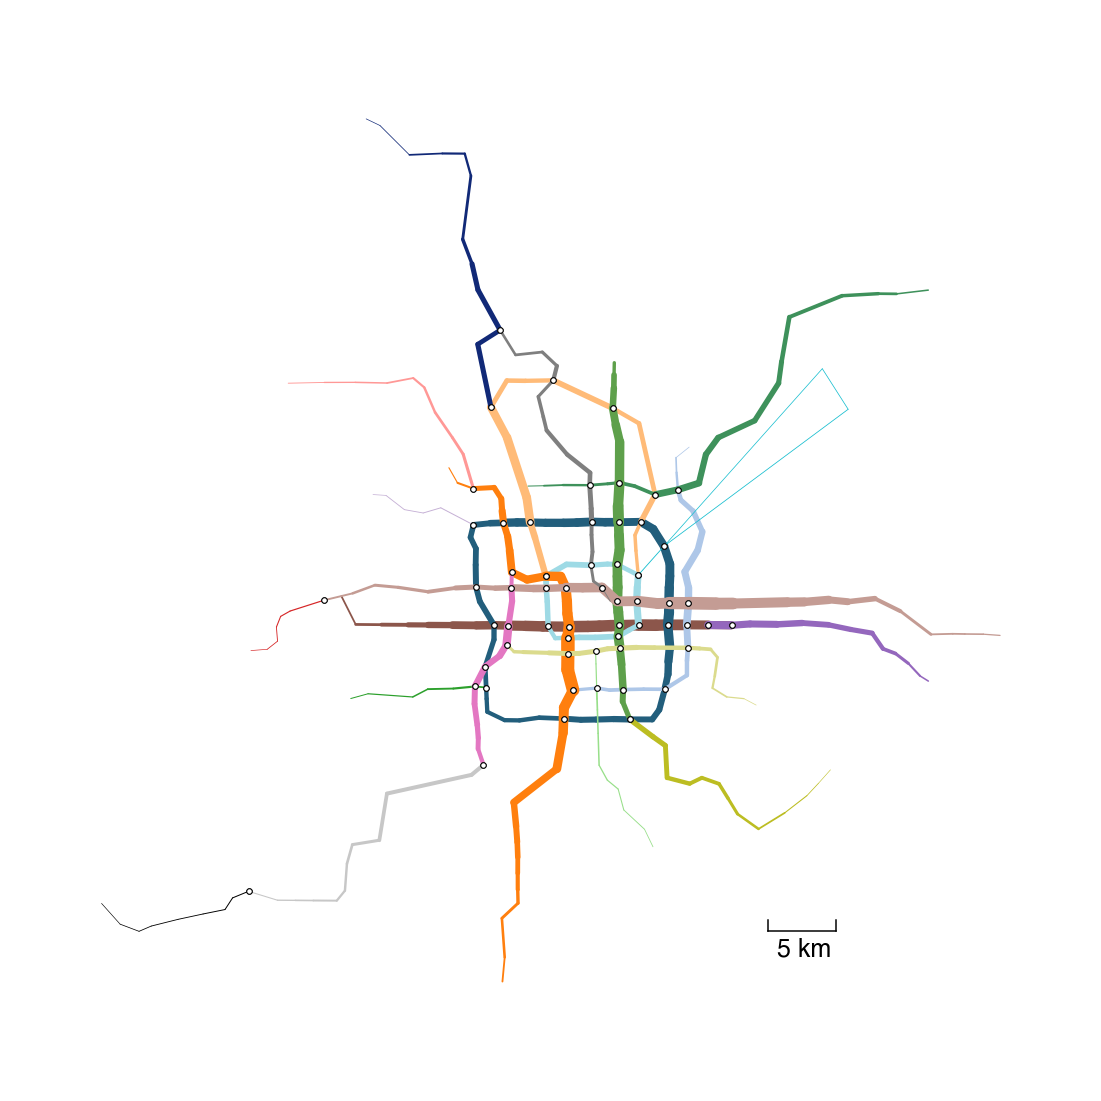

In [7]:
# generate the flow map
plt.figure(figsize=(20, 20))

nodes = nx.draw_networkx_nodes(
    H_relabeled,
    pos=node_pos_relabeled,
    node_size=30,
    node_color="white",
    edgecolors="black",
    linewidths=1,
    nodelist=[node for node in H_relabeled.nodes if int(node.split('-')[1]) in [ex[2] for ex in dualH_edges_sub]])

subedges = nx.draw_networkx_edges(H_relabeled,
                                  pos=node_pos_relabeled,
                                  node_size=0,
                                  arrowstyle="-",
                                  edge_color=[cgen[e[2] - 1] for e in edgelist],
                                  edge_cmap=plt.cm.tab20,
                                  edge_vmin=1,
                                  edge_vmax=25,
                                  width=edgewidth,
                                  edgelist=edgelist)


plt.gca().set_aspect('equal', adjustable='box')
x_center = plt.gca().get_xlim()
width = (x_center[1] - x_center[0]) / 2
x_center = (x_center[0] + x_center[1]) / 2
y_center = plt.gca().get_ylim()
y_center = (y_center[0] + y_center[1]) / 2


x_len = width
y_len = x_len
plt.xlim(x_center - x_len, x_center + x_len)
plt.ylim(y_center - y_len, y_center + y_len)
x1 = x_center + x_len / 2.5
x2 = x_center + x_len / 2.5 + 5000
y0 = y_center - y_len * 0.7
dy = 800
plt.plot([x1, x2], [y0, y0], 'black')
plt.plot([x1, x1], [y0, y0 + dy], 'black')
plt.plot([x2, x2], [y0, y0 + dy], 'black')
plt.annotate("5 km", xy=((x1 + x2) / 2, y0), xytext=(-25, -25),
             textcoords='offset points', fontsize=25)


plt.axis('off')

# plt.savefig('pic/flow.png',dpi=600)
# plt.savefig('pic/flow.svg',dpi=600)

(0.0, 1.0, 0.0, 1.0)

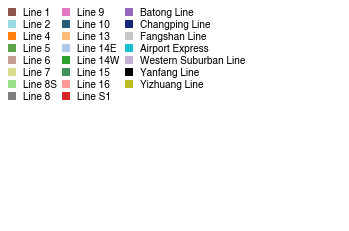

In [8]:
# generate the legend
dual_nodes_en = [(1, {'name': 'Line 1'}),
                 (2, {'name': 'Line 2'}),
                 (3, {'name': 'Line 4'}),
                 (4, {'name': 'Line 5'}),
                 (5, {'name': 'Line 6'}),
                 (6, {'name': 'Line 7'}),
                 (7, {'name': 'Line 8S'}),
                 (8, {'name': 'Line 8'}),
                 (9, {'name': 'Line 9'}),
                 (10, {'name': 'Line 10'}),
                 (11, {'name': 'Line 13'}),
                 (12, {'name': 'Line 14E'}),
                 (13, {'name': 'Line 14W'}),
                 (14, {'name': 'Line 15'}),
                 (15, {'name': 'Line 16'}),
                 (16, {'name': 'Line S1'}),
                 (17, {'name': 'Batong Line'}),
                 (18, {'name': 'Changping Line'}),
                 (19, {'name': 'New Airport Line'}),
                 (20, {'name': 'Fangshan Line'}),
                 (21, {'name': 'Airport Express'}),
                 (22, {'name': 'Western Suburban Line'}),
                 (23, {'name': 'Yanfang Line'}),
                 (24, {'name': 'Yizhuang Line'})]


patches = [mpatches.Patch(color=cgen[dual_nodes_en[n][0] - 1],
                          label="{:s}".format(dual_nodes_en[n][1]['name']),
                          alpha=1) for n in range(len(dual_nodes_en)) if dual_nodes_en[n][0] in dualH_sub.nodes]

plt.legend(
    handles=patches,
    ncol=3,
    fontsize=12,
    columnspacing=0.5,
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    handlelength=0.7,
    labelspacing=0.2,
    borderpad=0.1,
    prop={
        "family": "Helvetica"})  # 生成legend
plt.axis('off')

# plt.savefig('pic/legend.png',dpi=600)
# plt.savefig('pic/legend.svg',dpi=600)

In [9]:
# Correlation between the estimated flow and the official released flow
df_matched_paths = list_df_matched_paths[0]
df_matched_paths = df_matched_paths.reset_index(drop=True)
arr_counts = np.array([0.0 for _ in dual_nodes_en])
for idx in df_matched_paths.index:
    seq = eval(df_matched_paths['seq_lines'][idx])
    if(seq != []):
        arr_counts[np.array(seq) - 1] += df_matched_paths['avg_counts'][idx]

# import the official released flow 
df_flow_stat = pd.read_csv('flow_official.csv') #(2019/5/11 removed)
cols = df_flow_stat.columns
dict_flow_stat = {df_flow_stat[cols[0]][i]:[df_flow_stat[col][i] for col in cols[1:]] for i in range(len(df_flow_stat[cols[0]]))}

empirical_stat = [arr_counts[i] if dual_nodes_en[i][1]['name'].upper()
                  in dict_flow_stat else None for i in range(len(dual_nodes_en))]
empirical_stat = np.array(empirical_stat).astype(np.float64)
empirical_stat = empirical_stat[np.isnan(empirical_stat)==False]
empirical_stat = empirical_stat / sum(empirical_stat)

name_stat = [node[1]['name']if node[1]['name'].upper()
             in dict_flow_stat else None for node in dual_nodes_en]
name_stat = np.array(name_stat).astype(np.str_)
name_stat =  name_stat[name_stat  != 'None']

observe_stat = [sum(dict_flow_stat[node[1]['name'].upper()])
                if node[1]['name'].upper() in dict_flow_stat
                else None 
                for node in dual_nodes_en]
observe_stat = np.array(observe_stat).astype(np.float64)
observe_stat = observe_stat[np.isnan(observe_stat)==False]
observe_stat = observe_stat / sum(observe_stat)


# empirical_stat = empirical_stat.astype(np.float64)
observe_stat = observe_stat.astype(np.float64)

corr_stat = pd.DataFrame({'observation': empirical_stat * 100,
                          'estimation': observe_stat * 100,
                          'line': name_stat,
                          'snapshot': snapshot
                          })

model = LinearRegression()
model = model.fit(corr_stat[corr_stat['snapshot'] == snapshot]['estimation'].values.reshape(
    (-1, 1)), corr_stat[corr_stat['snapshot'] == snapshot]['observation'].values.reshape((-1, 1)))
'''get result
y = b0 + b1x
'''
r_sq = model.score(corr_stat[corr_stat['snapshot'] == snapshot]['estimation'].values.reshape(
    (-1, 1)), corr_stat[corr_stat['snapshot'] == snapshot]['observation'].values.reshape((-1, 1)))

print('coefficient of determination(𝑅²) : %.4f' % r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


coefficient of determination(𝑅²) : 0.9875
intercept: [0.01061829]
slope: [[0.99830107]]


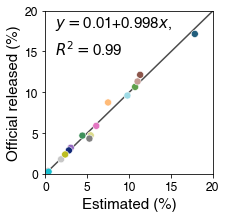

In [10]:
# regression plot

plt.figure(figsize=(3, 3))
snapshot = '2019'
[matrix_Ss,
    matrix_nroutes,
    matrix_pathlength,
    matrix_pathdist,
    matrix_S_nid,
    matrix_S_nid_C2,
    matrix_S_nid_C3,
 matrix_S_nid_C4] = load_variable('data/output/TSI/bj_' + snapshot + '_card.pkl')

pt = sns.scatterplot(data=corr_stat[corr_stat['snapshot'] == snapshot], x='estimation', y='observation'  # ,label='2016  r = 0.997'
                     , hue='line', palette={n[1]['name']: cgen[n[0] - 1] for n in dual_nodes_en}, s=50, alpha=1, legend=False
                     )
pt.set_zorder(100)

x = np.arange(0, 21)
y = model.intercept_[0] + model.coef_[0][0] * x
l = plt.plot(x, y, 'black', alpha=0.7, zorder=-1)


plt.annotate('$y=$' +
             str(round(model.intercept_[0], 2)) +
             '+' + str(round(model.coef_[0][0], 3))
             + '$x$,\n',
             xy=(1, 14),

             #                  xytext = (-10,10),
             size=15,
             textcoords='offset points',
             #                  weight='bold'
             )

plt.annotate('$R^2=$' + str(round(r_sq, 2)),
             xy=(1, 13),
             size=15,
             textcoords='offset points',

             )


plt.xlabel('Estimated (%)', fontdict={"fontsize": 15})
plt.ylabel('Official released (%)', fontdict={"fontsize": 15})
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, 5, 10, 15, 20])
plt.xlim(0, 20)
plt.ylim(0, 20)

plt.tick_params(labelsize=12)
# plt.savefig('pic/correlation'+snapshot+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig('pic/correlation'+snapshot+'.png',format = "png",dpi=600,transparent = True,bbox_inches = 'tight')



3
4
7
8.0
3
4
6
8.0
2
2
4
5.0


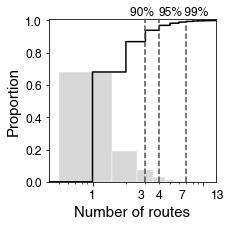

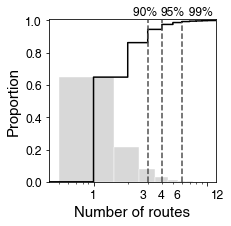

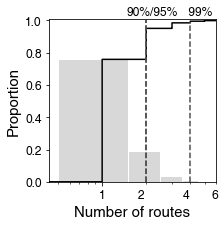

In [11]:
# The number of routes between stations

for i in range(len(list_df_Ss_i_j)):
    plt.figure(figsize=(3, 3))
    city_idx = i # Beijing
    city_abbr = files[city_idx][0]
    suffix = files[city_idx][1]
    snapshot = suffix[:4]
    color1 = color((79, 79, 79))
    color2 = 'gray'
    color3 = 'black'

    df_Ss_i_j0 = list_df_Ss_i_j[i]
    sns.ecdfplot(
        data=df_Ss_i_j0,
        x='k_paths',
        y=None,
        hue=None,
        stat='proportion',
        label='station level',
        legend=True,
        ax=None,
        color=color3)

    graph = sns.histplot(
        x='k_paths',
        data=df_Ss_i_j0,
        stat='probability',
        color=color2,
        edgecolor='white',
        discrete=True,
        alpha=0.3)

    perc_conf = 0.90
    for k in range(1, df_Ss_i_j0['k_paths'].max() + 1):
        if(len(df_Ss_i_j0[df_Ss_i_j0['k_paths'] <= k]) > len(df_Ss_i_j0['avg_counts']) * perc_conf):
            print(k)
            break

    plt.plot(np.array([k, k]), [0, 1], 'g--', color=color1)
    if(i==2):
        plt.annotate("%d%%/95%%" % (perc_conf * 100), xy=(k, 1),
                     xytext=(-20, 5), textcoords='offset points', fontsize=12)
        plt.annotate("%d" % (k), xy=(k, 0), xytext=(-8, -16),
                     textcoords='offset points', fontsize=12)    
    else:     
        plt.annotate("%d%%      " % (perc_conf * 100), xy=(k, 1),
                     xytext=(-15, 5), textcoords='offset points', fontsize=12)
        plt.annotate("%d" % (k), xy=(k, 0), xytext=(-8, -16),
                     textcoords='offset points', fontsize=12)

    perc_conf = 0.95
    for k in range(1, df_Ss_i_j0['k_paths'].max() + 1):
        if(len(df_Ss_i_j0[df_Ss_i_j0['k_paths'] <= k]) > len(df_Ss_i_j0['avg_counts']) * perc_conf):
            print(k)
            break

    plt.plot(np.array([k, k]), [0, 1], 'g--', color=color1)
    if i<2:
        plt.annotate("%d%%" % (perc_conf * 100), xy=(k, 1),
                     xytext=(-1, 5), textcoords='offset points', fontsize=12)
        plt.annotate("%d" % (k), xy=(k, 0), xytext=(-4, -16),
                     textcoords='offset points', fontsize=12)
#     else:
#         plt.annotate("%d%%" % (perc_conf * 100), xy=(k, 1),
#                      xytext=(2, 5), textcoords='offset points', fontsize=12,ha='center')
#         plt.annotate("%d" % (k), xy=(k, 0), xytext=(-4, -16),
#                      textcoords='offset points', fontsize=12)
        
    perc_conf = 0.99
    for k in range(1, df_Ss_i_j0['k_paths'].max() + 1):
        if(len(df_Ss_i_j0[df_Ss_i_j0['k_paths'] <= k]) > len(df_Ss_i_j0['avg_counts']) * perc_conf):
            print(k)
            break

    plt.plot(np.array([k, k]), [0, perc_conf], 'g--', color=color1)
    xy = (k, perc_conf)
    if i==1:
        plt.annotate("  %d%%" % (perc_conf * 100), xy=(k, 1),
                     xytext=(0, 5), textcoords='offset points', fontsize=12)
        plt.annotate("%d" % (k), xy=(k, 0), xytext=(-8, -16),
                     textcoords='offset points', fontsize=12)
    else:
        plt.annotate(" %d%%" % (perc_conf * 100), xy=(k, 1),
             xytext=(-5, 5), textcoords='offset points', fontsize=12)
        plt.annotate("%d" % (k), xy=(k, 0), xytext=(-8, -16),
                 textcoords='offset points', fontsize=12)

    ax = plt.gca()

    plt.ylabel('Proportion', fontdict={'font': 'Helvetica', "fontsize": 15})
    plt.xscale('log')
    plt.xlabel(
        'Number of routes',
        fontdict={
            "family": "Helvetica",
            "fontsize": 15})
    plt.tick_params(labelsize=12)
    plt.annotate("%d" % ( np.percentile(df_Ss_i_j0['k_paths'],99.9)), xy=( np.percentile(df_Ss_i_j0['k_paths'],99.9), 0)
                 , xytext=(-5, -13),
                 textcoords='offset points', fontsize=12,va = 'center')    
    print(np.percentile(df_Ss_i_j0['k_paths'],99.5))
    
#     plt.xlim(0.5, np.percentile(df_Ss_i_j0['k_paths'],99.9))
    plt.xlim(0, np.percentile(df_Ss_i_j0['k_paths'],99.9))
    plt.ylim(0, 1.01)
    label_vals = ax.get_xticklabels()
    label_vals[4] = str(100)
    label_vals[2] = str(1)
#     label_vals[3] = str(10)
    r = ax.set_xticklabels(
        label_vals,
        fontdict={
            "fontsize": 12,
            'font': 'Helvetica'})

    plt.tick_params(labelsize=12)
#     plt.savefig('pic/k_ecdf'+snapshot+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
#     plt.savefig('pic/k_ecdf'+snapshot+'.png',format = "png",dpi=100,transparent = True,bbox_inches = 'tight')
#     graph.patches[0].set_width(0.8)


In [12]:
# Combine the results of TSI and ESI

list_df_Sst = []
for i in range(len(list_df_matched_paths)):
    df_Ss_i_j = list_df_Ss_i_j[i]
    df_matched_paths = list_df_matched_paths[i]

    file = files[i]
    city_abbr = file[0]
    suffix = file[1]
    snapshot = suffix[:4]

    df_Sst = pd.DataFrame()


    # read the line list
    tb = pd.read_csv('data/subway_info/lines_'+city_abbr+'.csv')
    dict_lines = {tb['lineid'].iloc[i]:tb['linename'].iloc[i] for i in range(len(tb))}

    max_line_id = max(dict_lines)
    
    # read the station list
    tb = pd.read_csv('data/subway_info/stations_'+city_abbr+'.csv')
    dict_stations = {tb['stationid'].iloc[i]:tb['stationname'].iloc[i] for i in range(len(tb))}
    
    list_nodeid = [x for x in dict_stations]
    mat_width = max(list_nodeid)
    
    # read the results of TSI
    [
        matrix_Ss,
        matrix_nroutes,
        matrix_pathlength,
        matrix_pathdist,
        matrix_S_nid,
        matrix_S_nid_C1,
        matrix_S_nid_C2,
        matrix_S_nid_C3] = load_variable(
        'data/output/TSI/' +
        city_abbr +
        '_' +
        snapshot +
        '_card' +
        '.pkl')

    # read the subway network of Beijing subway in 2019
    H0 = nx.read_gml('data/networks/PrimalGraph_'+city_abbr+'_card.gml') 

    # read the information network of Beijing subway in 2019
    dualH_sub = nx.read_gml('data/networks/DualGraph_'+city_abbr+'_card.gml', destringizer=int)  # the network is used for route matching and the transfer delay is set specifically based on the smart card data (Beijing: 402s, Shanghai: 431s, Shenzhen: 376s).

    dualH_nodes_sub = list(dualH_sub.nodes(data=True))
    dualH_edges_sub = list(dualH_sub.edges(data=True,keys=True))


    df_Sij = pd.DataFrame()
    df_Sij['i'] = [i+1 for i in range(len(matrix_Ss)) for j in range(len(matrix_Ss[i]))]
    df_Sij['j'] = [j+1 for i in range(len(matrix_Ss)) for j in range(len(matrix_Ss[i]))]
    df_Sij['mindura'] = matrix_pathlength.flatten()
    df_Sij['minC'] = matrix_nroutes.flatten()-1

    df_Sst['i'] = [i + 1 for i in range(len(matrix_S_nid))
                   for j in range(len(matrix_S_nid[i]))]
    df_Sst['j'] = [j + 1 for i in range(len(matrix_S_nid))
                   for j in range(len(matrix_S_nid[i]))]

    k = '∞'
    df_Sst[k] = matrix_S_nid.flatten()
    df_Sst[k + '-1'] = matrix_S_nid_C1.flatten()
    df_Sst[k + '-2'] = matrix_S_nid_C2.flatten()
    df_Sst[k + '-3'] = matrix_S_nid_C3.flatten()

    [matrix_S_nid,
     matrix_S_nid_C1,
     matrix_S_nid_C2,
     matrix_S_nid_C3,
     ] = load_variable('data/output/ESI/res_linelevel_card_' + suffix + '.pkl')
    k = 'obs'
    df_Sst[k] = matrix_S_nid.flatten()
    df_Sst[k + '-1'] = matrix_S_nid_C1.flatten()
    df_Sst[k + '-2'] = matrix_S_nid_C2.flatten()
    df_Sst[k + '-3'] = matrix_S_nid_C3.flatten()

    minC = get_matrixC(dualH_sub, dualH_nodes_sub,
                       max_line_id)
    df_Sst['Cmin'] = minC.flatten()

    matrix_C = merge_2_st_matching_C(H0, df_matched_paths, 
                                     max_line_id, count_weighted=True)

    df_Sst['C'] = matrix_C.flatten()

    df_Sst['C_i'] = df_Sst['C'] + 0.5
    df_Sst.loc[np.isnan(df_Sst['C_i']) == False, 'C_i'] = df_Sst[np.isnan(
        df_Sst['C_i']) == False]['C_i'].astype(np.int)

    df_Ss_i_j['duration'] /= 60
    df_Ss_i_j['nroutes'] -= 1
    df_Ss_i_j['min_nroutes'] -= 1
    df_Ss_i_j = df_Ss_i_j.merge(df_Sij, on=['i', 'j'])
    df_Ss_i_j['mindura'] /= 60
    list_df_Ss_i_j[i] = df_Ss_i_j
    list_df_Sst.append(df_Sst)


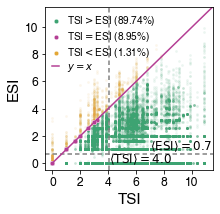

In [13]:
plt.figure(figsize=(3, 3))

df_Ss_i_j0 = list_df_Ss_i_j[0] # index 0:Beijing, 1: Shanghai. 2:Shenzhen

color1 = color((61, 163, 114))
color2 = color((227, 167, 53))
color3 = color((180, 62, 148))

g0 = sns.scatterplot(
    data=df_Ss_i_j0[(df_Ss_i_j0['S_const'] > df_Ss_i_j0['S_sub'])], x='S_const', y='S_sub', s=5, color=color1, alpha=0.1, edgecolor=None, legend=False
)
g0 = sns.scatterplot(data=df_Ss_i_j0[(df_Ss_i_j0['S_const'] < df_Ss_i_j0['S_sub'])],
                     x='S_const', y='S_sub', s=5, color=color2, alpha=0.1, edgecolor=None, legend=False)
g0 = sns.scatterplot(data=df_Ss_i_j0[(df_Ss_i_j0['S_const'] == df_Ss_i_j0['S_sub'])],
                     x='S_const', y='S_sub', s=20, color=color3, legend=False)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'TSI$>$ESI (%.2f%%)' % (len(df_Ss_i_j0[(
    df_Ss_i_j0['S_const'] > df_Ss_i_j0['S_sub'])]) / len(df_Ss_i_j0) * 100), s=20, color=color1)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'TSI$=$ESI (%.2f%%)' % (len(df_Ss_i_j0[(
    df_Ss_i_j0['S_const'] == df_Ss_i_j0['S_sub'])]) / len(df_Ss_i_j0) * 100), s=20, color=color3)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'TSI$<$ESI (%.2f%%)' % (len(df_Ss_i_j0[(
    df_Ss_i_j0['S_const'] < df_Ss_i_j0['S_sub'])]) / len(df_Ss_i_j0) * 100), s=20, color=color2)

sns.lineplot([0, 11.5], [0, 11.5], color=color3, label='$y=x$', legend=False
             )
plt.axvline(
    x=np.average(
        df_Ss_i_j0['S_const']), color='gray', dashes=(
            3, 2), zorder=1)
plt.axhline(
    y=np.average(
        df_Ss_i_j0['S_sub']), color='gray', dashes=(
            3, 2), zorder=1)
ax = plt.gca()

h, l = ax.get_legend_handles_labels()
plt.legend([h[1],
            h[2],
            h[3],
            h[0]],
           [l[1],
            l[2],
            l[3],
            l[0]],
           borderaxespad=0.2,
           frameon=False,
           handlelength=0.7,
           labelspacing=0.2,
           borderpad=0.5,
           fontsize=10,
           loc='upper left')

plt.annotate(
    r"$\langle \rm{ESI}\rangle=%.1f $" %
    np.average(
        df_Ss_i_j0['S_sub']), xy=(
            7, np.average(
                df_Ss_i_j0['S_sub']) + 0.3), xytext=(
                    0, 0), textcoords='offset points', fontsize=12)
plt.annotate(
    r"$\langle \rm{TSI}\rangle=%.1f $" %
    np.average(
        df_Ss_i_j0['S_const']), xy=(
            np.average(
                df_Ss_i_j0['S_const']), 0), xytext=(
                    0, 0), textcoords='offset points', fontsize=12)

ax.set_xlim(-0.5, 11.5)
ax.set_ylim(-0.5, 11.5)
ax.set_xlabel(xlabel='TSI', fontdict={"family": "Helvetica", "fontsize": 15})
ax.set_ylabel(ylabel='ESI', fontdict={"family": "Helvetica", "fontsize": 15})
ax.set_xticks([0, 2, 4, 6, 8, 10])
plt.tick_params(labelsize=12)

picname = 'pic/TSI_ESI_Ss'
# plt.savefig(picname+'.svg',format = "svg",dpi=100,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.png',format = "png",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.eps',format = "eps",dpi=600,transparent = True,bbox_inches = 'tight')


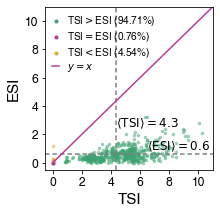

In [14]:
plt.figure(figsize=(3, 3))

df_Sst = list_df_Sst[0] # index 0:Beijing, 1: Shanghai. 2:Shenzhen

g0 = sns.scatterplot(data=df_Sst[(df_Sst['∞'] > df_Sst['obs'])],
                     x='∞',
                     y='obs',
                     s=10,
                     color=color1,
                     alpha=0.5,
                     edgecolor=None,
                     legend=False)
g0 = sns.scatterplot(data=df_Sst[(df_Sst['∞'] < df_Sst['obs'])],
                     x='∞',
                     y='obs',
                     color=color2,
                     s=10,
                     alpha=0.5,
                     edgecolor=None,
                     legend=False)
g0 = sns.scatterplot(data=df_Sst[(
    df_Sst['∞'] == df_Sst['obs'])], x='∞', y='obs', s=20, color=color3, legend=False)

g0 = sns.scatterplot(x=[-1], y=[-1], label=r'TSI$>$ESI (%.2f%%)' % (len(df_Sst[(df_Sst['∞'] >
                                                                                df_Sst['obs'])]) / len(df_Sst[np.isnan(df_Sst['∞']) != True]) * 100), s=20, color=color1)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'TSI$=$ESI (%.2f%%)' % (len(df_Sst[(df_Sst['∞'] ==
                                                                                df_Sst['obs'])]) / len(df_Sst[np.isnan(df_Sst['∞']) != True]) * 100), s=20, color=color3)
g0 = sns.scatterplot(x=[-1], y=[-1], label=r'TSI$<$ESI (%.2f%%)' % (len(df_Sst[(df_Sst['∞'] <
                                                                                df_Sst['obs'])]) / len(df_Sst[np.isnan(df_Sst['∞']) != True]) * 100), s=20, color=color2)

sns.lineplot([0, 11.5], [0, 11.5], color=color3, label='$y=x$')
ax.set_xlim(0, 12)
plt.axvline(x=np.nanmean(df_Sst[np.isnan(
    df_Sst['∞']) == False]['∞']), color='gray', dashes=(3, 2), zorder=1)
plt.axhline(y=np.nanmean(df_Sst[np.isnan(
    df_Sst['∞']) == False]['obs']), color='gray', dashes=(3, 2), zorder=1)
ax = plt.gca()
ax.set_xlim(-0.5, 11)
ax.set_ylim(-0.5, 11)

h, l = ax.get_legend_handles_labels()
plt.legend(
    #     h,l
    [h[1], h[2], h[3], h[0]], [l[1], l[2], l[3], l[0]], borderaxespad=0.2, frameon=False, handlelength=0.7, labelspacing=0.2, borderpad=0.5, fontsize=10, loc='upper left'
    #            ,prop={"family" : "Helvetica"}
)

plt.annotate(r"$\langle \rm{ESI}\rangle=%.1f $" % np.nanmean(df_Sst[np.isnan(df_Sst['∞']) == False]['obs']), xy=(
    6.5, np.nanmean(df_Sst[np.isnan(df_Sst['∞']) == False]['obs']) + 0.3), xytext=(0, 0), textcoords='offset points', fontsize=12)
plt.annotate(r"$\langle \rm{TSI}\rangle=%.1f $" % np.nanmean(df_Sst[np.isnan(df_Sst['∞']) == False]['∞']), xy=(
    np.nanmean(df_Sst[np.isnan(df_Sst['∞']) == False]['∞']), 2.5), xytext=(0, 0), textcoords='offset points', fontsize=12)

ax.set_xlabel(xlabel='TSI', fontdict={"family": "Helvetica", "fontsize": 15})
ax.set_ylabel(ylabel='ESI', fontdict={"family": "Helvetica", "fontsize": 15})
ax.set_xticks([0, 2, 4, 6, 8, 10])

plt.tick_params(labelsize=12)

picname = 'pic/TSI_ESI_Sl'
# plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.eps',format = "eps",dpi=600,transparent = True,bbox_inches = 'tight')



In [15]:
df_Ss_i_j

,i,j,S_sub,avg_counts,k_paths,nroutes,min_nroutes,duration,Ktot_sub,S_const,mindura,minC
0,1,2,0.0,642.0,1,0.0,0.0,53.0,0,-0.0,53.0,0.0
1,1,3,0.0,5417.0,1,0.0,0.0,8.0,0,-0.0,8.0,0.0
2,1,4,0.0,1729.0,1,0.0,0.0,29.0,0,-0.0,29.0,0.0
3,1,5,0.0,2207.0,1,0.0,0.0,13.0,0,-0.0,13.0,0.0
4,1,6,0.0,881.0,1,0.0,0.0,26.0,0,-0.0,26.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
25899,236,231,0.0,1203.0,1,0.0,0.0,11.0,0,-0.0,11.0,0.0
25900,236,232,0.0,552.0,1,0.0,0.0,8.0,0,-0.0,8.0,0.0
25901,236,233,0.0,847.0,1,0.0,0.0,24.0,0,-0.0,24.0,0.0
25902,236,234,0.0,534.0,1,0.0,0.0,35.0,0,-0.0,35.0,0.0


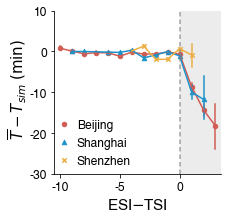

In [16]:
plt.figure(figsize=(3,3))
list_color=[color((209,92,83)),color((30,147,201)),color((235,175,70))]
markers = ['o', '^', 'x']

for i in range(len(list_df_matched_paths)):
    df_Ss_i_j = list_df_Ss_i_j[i]
    file =  files[i]
    city_abbr = file[0]
    suffix = file[1]
    snapshot = suffix[:4]

    df_Ss_i_j0 = df_Ss_i_j.copy(deep=True)
    df_Ss_i_j0['duration']
    df_Ss_i_j0['Tdiff'] = df_Ss_i_j0['duration'] - df_Ss_i_j0['mindura']
    df_Ss_i_j0['S_diff'] = df_Ss_i_j0['S_sub'] - df_Ss_i_j0['S_const']

    df_Ss_i_j0['Cdiff'] = df_Ss_i_j0['nroutes'] - df_Ss_i_j0['minC']
    
    dia = 'S_diff'
    diameter1 = np.percentile( df_Ss_i_j0[dia],99.99)
    diameter2 = np.percentile( df_Ss_i_j0[dia],0.01)
    df_Ss_i_j0 =  df_Ss_i_j0[(df_Ss_i_j0[dia]<=diameter1)&(df_Ss_i_j0[dia]>=diameter2)]

    df_Ss_i_j0['nroutes_i'] =np.int64(df_Ss_i_j0['S_diff']+0.5)

    sns.lineplot(
        data = df_Ss_i_j0,
               x=  'nroutes_i'
               
               
                ,y = 'Tdiff'

                 , ci=95
                ,color = list_color[i]# 'black'
                ,err_style='bars'
                )
    
    ax=plt.scatter(
#     data = df_Ss_i_j0.groupby(by=['minC']).aggregate({'S_const':np.average,'S_sub':np.average})[ 'minC']
    x= df_Ss_i_j0.groupby(by=['nroutes_i'],as_index=False).aggregate(
        { 'Tdiff':np.average,'mindura':np.average,'duration':np.average})['nroutes_i']
    ,y=df_Ss_i_j0.groupby(by=['nroutes_i'],as_index=False).aggregate(
        { 'Tdiff':np.average,'mindura':np.average,'duration':np.average})['Tdiff']
         ,label = city_abbr
#          ,edgecolors = list_color[i]#'black'
        ,color = list_color[i]#'black'
        ,s=20
         ,marker=markers[i]
    ) 


plt.ylabel(r'  $\overline{T}-T_{sim}$ $ (\min) $',fontdict={"family" : "Helvetica","fontsize":15}, labelpad=0.5)
plt.xlabel('ESI$-$TSI',fontdict={"fontsize":15})

plt.ylim(-30,10)
plt.xlim(-10.5,3.5)

ax = plt.gca()

plt.legend()
h,l = ax.get_legend_handles_labels()
l=['Beijing','Shanghai','Shenzhen']
plt.legend(h,l
           ,borderaxespad=0.2
           ,frameon=False
           ,handlelength=0.5
           ,labelspacing=0.5
           ,fontsize = 12
           ,loc = 'lower left'
)

x = np.array([0,3.5])
y = np.array([-30,-30])

plt.fill_between( x,y
                 ,facecolor ='gray'
                 ,zorder =-1
                 ,alpha=0.15
                )
x = np.array([0,3.5])
y = np.array([10,10])
plt.fill_between( x,y
                 ,facecolor ='gray'
                 ,zorder =-1
                 ,alpha=0.15
                )

plt.axvline(x = 0,color = 'gray',alpha=0.7,dashes = ((3,2)))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(labelsize=12)



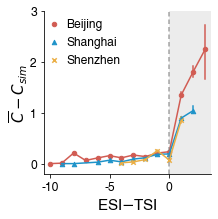

In [17]:
plt.figure(figsize=(3,3))
list_color=[color((209,92,83)),color((30,147,201)),color((235,175,70))]
markers = ['o', '^', 'x']

for i in range(len(list_df_Ss_i_j)):
    df_Ss_i_j = list_df_Ss_i_j[i]
    file =  files[i]
    city_abbr = file[0]
    suffix = file[1]
    snapshot = suffix[:4]

    df_Ss_i_j0 = df_Ss_i_j.copy(deep=True)
    df_Ss_i_j0['Tdiff'] = df_Ss_i_j0['duration'] - df_Ss_i_j0['mindura']
    df_Ss_i_j0['Sdiff'] =df_Ss_i_j0 ['S_sub']-df_Ss_i_j0 ['S_const']
    
    df_Ss_i_j0['Cdiff'] = df_Ss_i_j0['nroutes'] - df_Ss_i_j0['minC']
    
    dia = 'Sdiff'
    diameter1 = np.percentile( df_Ss_i_j0[dia],99.99)
    diameter2 = np.percentile( df_Ss_i_j0[dia],0.01)
    df_Ss_i_j0 =  df_Ss_i_j0[(df_Ss_i_j0[dia]<=diameter1)&(df_Ss_i_j0[dia]>=diameter2)]

    df_Ss_i_j0['nroutes_i'] =np.int64(df_Ss_i_j0['Sdiff']+0.5)

    sns.lineplot(
        data = df_Ss_i_j0
        ,x = 'nroutes_i'
        ,y = 'Cdiff'
        ,ci=95
        ,color = list_color[i]# 'black'
        ,err_style='bars'
    )
    
    ax=plt.scatter(
        x= df_Ss_i_j0.groupby(by=['nroutes_i'],as_index=False).aggregate(
            { 'Cdiff':np.average})['nroutes_i']
        ,y=df_Ss_i_j0.groupby(by=['nroutes_i'],as_index=False).aggregate({ 'Cdiff':np.average})['Cdiff']
        ,label = city_abbr
        ,color = list_color[i]
        ,s=20
        ,marker=markers[i]
    ) 


plt.ylabel('$\overline{C}-C_{sim}$',fontdict={"fontsize":15}, labelpad=0.5)
plt.xlabel('ESI$-$TSI',fontdict={"fontsize":15})

plt.ylim(-0.2,3)
plt.xlim(-10.5,3.5)

ax = plt.gca()

plt.legend()
h,l = ax.get_legend_handles_labels()
l=['Beijing','Shanghai','Shenzhen']
plt.legend(h,l
           ,borderaxespad=0.2
           ,frameon=False
           ,handlelength=0.5
           ,labelspacing=0.5
           ,fontsize = 12
)

x = np.array([0,3.5])
y = np.array([3,3])

plt.fill_between( x,y
                 ,facecolor ='gray'
                 ,zorder =-1
                 ,alpha=0.15
                )
x = np.array([0,3.5])
y = np.array([-1,-1])

plt.fill_between( x,y
                 ,facecolor ='gray'
                 ,zorder =-1
                 ,alpha=0.15
                )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(labelsize=12)
plt.axvline(x = 0,color = 'gray',alpha=0.7,dashes = ((3,2)))


In [19]:

avg_S2 = pd.DataFrame()
list_slopes = []
list_R2 = []

avg_S2 = pd.DataFrame()
timelines = [
    ['2003', '2004', '2007', '2008', '2009', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    ['2000','2003','2004','2005','2006','2007','2008','2009','2010', '2011','2012','2013','2014','2015','2016','2017','2018','2020'], 
    ['2004','2007','2009','2010','2011','2016','2019','2020']
]
cities = ['bj', 'sh', 'sz']
list_k = ['13', '12', '6']
for i in range(len(cities)):
    city_abbr = cities[i]
   
    for k in [list_k[i]]:
        for snapshot in timelines[i]:
            # read the subway network of Beijing subway in 2019
            H0 = nx.read_gml('data/networks/PrimalGraph_'+city_abbr+'_'+snapshot+'.gml') 

            # read the information network of Beijing subway in 2019
            dualH_sub = nx.read_gml('data/networks/DualGraph_'+city_abbr+'_'+snapshot+'.gml', destringizer=int)  # the network is used for route matching and the transfer delay is set specifically based on the smart card data (Beijing: 402s, Shanghai: 431s, Shenzhen: 376s).

            dualH_nodes_sub = list(dualH_sub.nodes(data=True))
            dualH_edges_sub = list(dualH_sub.edges(data=True,keys=True))

            [
                matrix_Ss,
                matrix_nroutes,
                matrix_pathlength,
                matrix_pathdist,
                matrix_S_nid_1,
                matrix_S_nid_C1_1,
                matrix_S_nid_C2_1,
                matrix_S_nid_C3_1] = load_variable(
                'data/output/TSI/' +
                city_abbr +
                '_' +
                snapshot +
                '.pkl')

            [
                matrix_Ss_sub,
                matrix_nroutes_sub,
                matrix_pathlength_sub,
                matrix_pathdist_sub,
                matrix_Ktot_sub,
                matrix_S_nid,
                matrix_Ktot_st_sub,
                matrix_S_nid_C1,
                matrix_Ktot_st_C1_sub,
                matrix_S_nid_C2,
                matrix_Ktot_st_C2_sub,
                matrix_S_nid_C3,
                matrix_Ktot_st_C3_sub,
            ] = load_variable(
                'data/output/ESI/ksp_' +
                str(k) +
                '_' +
                city_abbr +
                '_' +
                snapshot +
                '.pkl')
            Ku = len(nx.Graph(dualH_sub).edges())

            avg_S2 = pd.concat([avg_S2,
                                pd.DataFrame({'city': city_abbr,
                                              'S': matrix_S_nid[(matrix_S_nid_1 > -1) & (matrix_S_nid > -1)].flatten(),
                                              'C':'all',
                                              'snapshot':snapshot,
                                              'k':k,
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city_abbr,
                                              'S': matrix_S_nid_C1[(matrix_S_nid_C1_1 > -1) & (matrix_S_nid_C1 > -1)].flatten(),
                                              'C':'1',
                                              'snapshot':snapshot,
                                              'k':k,
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city_abbr,
                                              'S': matrix_S_nid_C2[(matrix_S_nid_C2_1 > -1) & (matrix_S_nid_C2 > -1)].flatten(),
                                              'C':'2',
                                              'snapshot':snapshot,
                                              'k':k,
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city_abbr,
                                              'S': matrix_S_nid_C3[(matrix_S_nid_C3_1 > -1) & (matrix_S_nid_C3 > -1)].flatten(),
                                              'C':'3',
                                              'snapshot':snapshot,
                                              'k':k,
                                              'Ku':Ku})],
                               axis=0,
                               ignore_index=True)
            avg_S2 = pd.concat([avg_S2,
                                pd.DataFrame({'city': city_abbr,
                                              'S': matrix_S_nid_1[(matrix_S_nid_1 > -1) & (matrix_S_nid > -1)].flatten(),
                                              'C':'all',
                                              'snapshot':snapshot,
                                              'k':'∞',
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city_abbr,
                                              'S': matrix_S_nid_C1_1[(matrix_S_nid_C1_1 > -1) & (matrix_S_nid_C1 > -1)].flatten(),
                                              'C':'1',
                                              'snapshot':snapshot,
                                              'k':'∞',
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city_abbr,
                                              'S': matrix_S_nid_C2_1[(matrix_S_nid_C2_1 > -1) & (matrix_S_nid_C2 > -1)].flatten(),
                                              'C':'2',
                                              'snapshot':snapshot,
                                              'k':'∞',
                                              'Ku':Ku}),
                                pd.DataFrame({'city': city_abbr,
                                              'S': matrix_S_nid_C3_1[(matrix_S_nid_C3_1 > -1) & (matrix_S_nid_C3 > -1)].flatten(),
                                              'C':'3',
                                              'snapshot':snapshot,
                                              'k':'∞',
                                              'Ku':Ku})],
                               axis=0,
                               ignore_index=True)
        avg_S2 = avg_S2[(avg_S2['S'] > -1)]
        avg_S2['snapshot_f'] = avg_S2['snapshot']
        avg_S2['snapshot_f'] = avg_S2['snapshot_f'].astype(np.float)

        # plt.figure(figsize=(4,3))
max_S2 = avg_S2.groupby(by=['C',
                            'snapshot',
                            'snapshot_f',
                            'k',
                            'city',
                            'Ku'],
                        as_index=False).agg({'S': np.max})



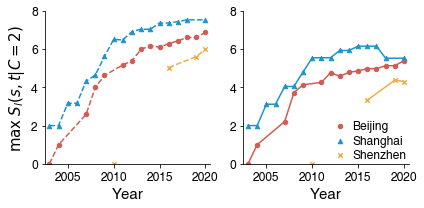

In [20]:
pd_S_all = avg_S2.groupby(by=['C',
                              'snapshot',
                              'snapshot_f',
                              'k',
                              'city',
                              'Ku'],
                          as_index=False).agg({'S': np.max})
pd_S_C2 = pd_S_all[pd_S_all['C'] == '2'].copy()

fig = plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
list_color = [
    color((209, 92, 83)),
    color((30, 147, 201)),
    color((235, 175, 70))]


sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'].isin(
    ['bj', 'sh']))], x='snapshot_f', y='S', hue='city', linestyle='--', palette=list_color[:2], legend=False)
sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'].isin(['sz'])) & (
    pd_S_C2['snapshot_f'] > 2011)], x='snapshot_f', y='S', hue='city', linestyle='--', palette=list_color[2:], legend=False)
for i in range(len(cities)):
    city_abbr = cities[i]
    ax = plt.scatter(x=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'] == city_abbr)]['snapshot_f'], y=pd_S_C2[(
        pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'] == city_abbr)]['S'], color=list_color[i], s=20, marker=markers[i], label=city_abbr)
plt.xlim(2002.5, 2020.5)
plt.ylim(0, 8)
ax = plt.gca()
ax.set_xticks([2005., 2010., 2015., 2020, ])
plt.gca().get_xlim()
plt.tick_params(labelsize=12)
plt.ylabel(r'$\max$ ${S_l(s,t| C=2)}$', fontdict={"fontsize": 15})

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(labelsize=12)
plt.xlabel('Year', fontdict={"fontsize": 15})


plt.subplot(1, 2, 2)
cities = ['bj', 'sh', 'sz']
list_k = ['13', '12', '6']
for i in range(len(cities)):
    city_abbr = cities[i]

    for k in [list_k[i]]:

        if(city_abbr == 'sz'):
            sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (
                pd_S_C2['snapshot_f'] > 2011)], x='snapshot_f', y='S', color=list_color[i])
            ax = plt.scatter(x=pd_S_C2[(pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (pd_S_C2['snapshot_f'] > 2011)]['snapshot_f'], y=pd_S_C2[(
                pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (pd_S_C2['snapshot_f'] > 2011)]['S'], color=list_color[i], s=20, marker=markers[i])

            ax = plt.scatter(x=pd_S_C2[(pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (pd_S_C2['snapshot_f'] == 2010)]['snapshot_f'], y=pd_S_C2[(
                pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2') & (pd_S_C2['snapshot_f'] == 2010)]['S'], color=list_color[i], s=20, marker=markers[i], label=city_abbr)
        else:
            sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == k) & (
                pd_S_C2['C'] == '2')], x='snapshot_f', y='S', color=list_color[i])
            ax = plt.scatter(
                x=pd_S_C2[(pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2')]['snapshot_f'], y=pd_S_C2[(
                    pd_S_C2['k'] == k) & (pd_S_C2['C'] == '2')]['S'], color=list_color[i]  # 'black'
                , s=20, marker=markers[i], label=city_abbr

            )


plt.xlim(2002.5, 2020.5)
plt.ylim(0, 8)
ax = plt.gca()
ax.set_xticks([2005., 2010., 2015., 2020, ])
plt.gca().get_xlim()
plt.xlabel('Year', fontdict={"fontsize": 15})
plt.tick_params(labelsize=12)
plt.ylabel(r'$\overline{S}_l(s,t)$', fontdict={"fontsize": 15})


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel(None)
plt.tick_params(labelsize=12)
plt.xlabel('Year', fontdict={"fontsize": 15})

ax = plt.gca()
plt.legend()
h, l = ax.get_legend_handles_labels()
l = ['Beijing', 'Shanghai', 'Shenzhen']
plt.legend(
    h,
    l,
    borderaxespad=0.2,
    frameon=False,
    handlelength=0.5,
    labelspacing=0.2,
    borderpad=0,
    fontsize=12,
    loc='lower right')


plt.tight_layout()


picname = 'pic_timeline/Slmax_year_cities'
# plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
# plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')


bj 13
coefficient of determination(𝑅²) : 0.98
intercept: 0.29
slope: 0.75
sh 12
coefficient of determination(𝑅²) : 0.97
intercept: 0.78
slope: 0.71
sz 6
coefficient of determination(𝑅²) : 0.98
intercept: -0.03
slope: 0.73


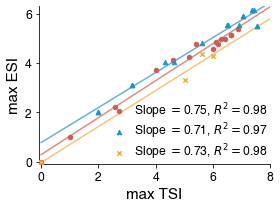

In [21]:
fig = plt.figure(figsize=(4,3))
list_slopes=[]
list_intercepts=[]
list_R2=[]
for i in range(len(cities)):
    city_abbr = cities[i]
    max_S2 = avg_S2.groupby(by=['C','snapshot','snapshot_f','k','city'],as_index=False).agg({'S':np.max})


    max_S2 = max_S2[max_S2['city']==city_abbr]

    k= list_k[i]
    
    C='2'
    model = LinearRegression()
    model = model.fit(max_S2[(max_S2['C']==C)&(max_S2['k']=='∞')] ['S'].values.reshape((-1, 1)),
                      max_S2[(max_S2['C']==C)&(max_S2['k']==list_k[i])]  ['S'].values.reshape((-1, 1)))
    # LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
    '''get result
    y = b0 + b1x
    '''
    r_sq = model.score(max_S2[(max_S2['C']==C)&(max_S2['k']=='∞')]['S'].values.reshape((-1, 1)),
                       max_S2[(max_S2['C']==C)&(max_S2['k']==list_k[i])]  ['S'].values.reshape((-1, 1)))
    print(city_abbr,k)
    R2 = round(r_sq,2)
    intercept = round(model.intercept_[0],2)
    slope = round(model.coef_[0][0],2)
    print('coefficient of determination(𝑅²) :', R2)
    print('intercept:', intercept)
    print('slope:', slope)
    list_slopes.append(slope)
    list_intercepts.append(intercept)
    list_R2.append(R2)

    x = np.arange(0,10)
    y = list_intercepts[i]+list_slopes[i]*x
    plt.plot(x,y,color= list_color[i]#color((77,77,77))
            ,alpha=0.7
            )

    ax=plt.scatter(
    #     data = pd_S_i_j0.groupby(by=['minC']).aggregate({'S_const':np.average,'S_sub':np.average})[ 'minC']
    x= max_S2[(max_S2['C']==C)&(max_S2['k']=='∞')] ['S']
    ,y=  max_S2[(max_S2['C']==C)&(max_S2['k']==list_k[i])]  ['S']
         ,color = list_color[i]#'black'
        ,s=20
         ,marker=markers[i]
        ,label = city_abbr
        ,zorder=5
    )     
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



plt.tick_params(labelsize=12)
plt.xlim(-0.08,8)
plt.ylim(-0.08,6.3)
plt.ylabel('max ESI',size=15)
plt.xlabel('max TSI',fontdict={"fontsize":15})

h,l = ax.get_legend_handles_labels()
l=['Beijing',
   'Shanghai',
   'Shenzhen']
for i in range(len(l)):
    l[i] = ' Slope $= $%.2f, $R^2=$%.2f '%(list_slopes[i],list_R2[i])
plt.legend(h,l
#     [h[0],h[2]],[l[0],l[2]]

    ,frameon=False
           ,columnspacing=0.1
           ,labelspacing=0.1
           ,borderaxespad=0
           ,handletextpad=0
           ,borderpad=0.2
           ,fontsize = 12
#            ,loc = 'upper left'
           ,loc='lower right'
#            ,prop={"family" : "Helvetica"}
)
# plt.plot([0,8],[0,6],color='tab:red')
# plt.axhline(y=6,color = 'black',dashes=(1,2) ,zorder  =1,lw=2)
# plt.axvline(x=8,color = color((99,99,99)),dashes=(1,2) ,zorder  =1,lw=3)
# plt.axhline(y=6,color=color((225,225,225)),zorder=-1)

# plt.axhline(y=4,color=color((225,225,225)),zorder=-1)
# plt.axhline(y=2,color=color((225,225,225)),zorder=-1)



plt.tight_layout()


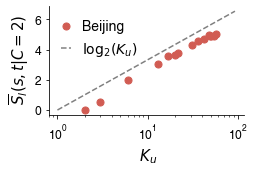

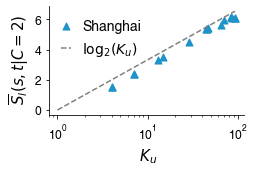

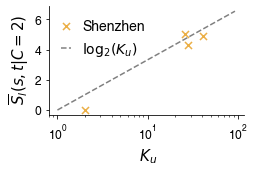

In [22]:
pd_S_all = avg_S2.groupby(by=['C',
                              'snapshot',
                              'snapshot_f',
                              'k',
                              'city',
                              'Ku'],
                          as_index=False).agg({'S': np.average})
pd_S_C2 = pd_S_all[pd_S_all['C'] == '2'].copy()
cities_name = ['Beijing', 'Shanghai', 'Shenzhen']


for i in range(len(cities)):
    fig = plt.figure(figsize=(3.5, 2))
    city_abbr = cities[i]
    ax = plt.scatter(x=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == '2') & (pd_S_C2['city'] == city_abbr)]['Ku'], y=pd_S_C2[(pd_S_C2['k'] == '∞') & (
        pd_S_C2['C'] == '2') & (pd_S_C2['city'] == city_abbr)]['S'], color=list_color[i], s=50, marker=markers[i], label=cities_name[i])

    plt.xscale('log')
    kt = np.linspace(1, pd_S_C2['Ku'].max() + 1, 20)
    plt.plot(kt, np.log2(kt), '--', color='gray', label=r'$\log_2(K_u)$')
    plt.legend(frameon=False, fontsize=12)
    plt.ylabel(r' ${\overline{S}_l(s,t|C=2)}$', fontdict={"fontsize": 15})
    plt.xlabel(' ${K_{u}}$', fontdict={"fontsize": 15})

    ax = plt.gca()
    h, l = ax.get_legend_handles_labels()
    plt.legend([h[1], h[0]], [l[1], l[0]], frameon=False,
               handlelength=0.7, labelspacing=0.5, fontsize=14, loc='upper left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(labelsize=12)

    picname = 'pic_timeline/Sl_Ku_' + city_abbr
#     plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
#     plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')


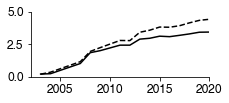

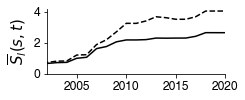

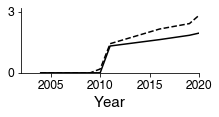

In [23]:
pd_S_all = avg_S2.groupby(by=['C',
                              'snapshot',
                              'snapshot_f',
                              'k',
                              'city',
                              'Ku'],
                          as_index=False).agg({'S': np.average})

pd_S_C2 = pd_S_all[pd_S_all['C'] == 'all'].copy()

cities = ['bj', 'sh', 'sz']
list_k = ['13', '12', '6']
for i in range(len(cities)):
    city_abbr = cities[i]

    plt.figure(figsize=(3.2, 1.2))
    list_color = [
        color((209, 92, 83)),
        color((30, 147, 201)),
        color((235, 175, 70))]
    sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == '∞') & (pd_S_C2['C'] == 'all') & (
        pd_S_C2['city'] == city_abbr)], x='snapshot_f', y='S', linestyle='--', color='black')

    for k in [list_k[i]]:
        sns.lineplot(data=pd_S_C2[(pd_S_C2['k'] == k) & (
            pd_S_C2['C'] == 'all')], x='snapshot_f', y='S', color='black')

    ax = plt.gca()
    ylims = [(0, 5), (0, 4.2), (0, 3.2)]
    yticks = [[0, 2.5, 5], [0, 2, 4], [0, 3]]
    plt.ylim(ylims[i])
    ax.set_yticks(yticks[i])
    plt.ylabel(None)

    plt.xlim(2002, 2020)
    plt.gca().get_xlim()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tick_params(labelsize=12)

    plt.xlabel(None)
    if(city_abbr == 'sz'):
        plt.xlabel('Year', fontdict={"fontsize": 15})
    if(city_abbr == 'sh'):
        plt.ylabel(r'$\overline{S}_l(s,t)$', fontdict={"fontsize": 15})

    picname = 'pic_timeline/Sl_' + city_abbr
#     plt.savefig(picname+'.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
#     plt.savefig(picname+'.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')
    # plt.savefig(picname+'.eps',format = "eps",dpi=600,transparent = True,bbox_inches = 'tight')


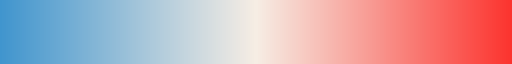

In [24]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(65 / 256, 247 / 256, N)
vals[:, 1] = np.linspace(150 / 256, 238 / 256, N)
vals[:, 2] = np.linspace(207 / 256, 229 / 256, N)
newcmp1 = ListedColormap(vals)

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(247 / 256, 253 / 256, N)
vals[:, 1] = np.linspace(238 / 256, 52 / 256, N)
vals[:, 2] = np.linspace(229 / 256, 47 / 256, N)
newcmp2 = ListedColormap(vals)
newcmp2
newcmp = np.vstack((newcmp1(np.linspace(0, 1, 128)),
                    newcmp2(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcmp)
newcmp

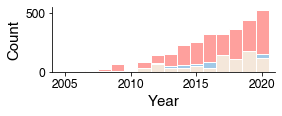

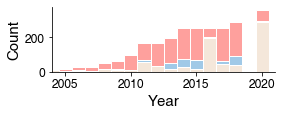

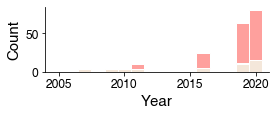

In [25]:
timelines = [
    ['2003', '2004', '2007', '2008', '2009', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    ['2000','2003','2004','2005','2006','2007','2008','2009','2010', '2011','2012','2013','2014','2015','2016','2017','2018','2020'], 
    ['2004','2007','2009','2010','2011','2016','2019','2020']
]
cities = ['bj', 'sh', 'sz']
list_k = ['13', '12', '6']

for i in range(len(cities)):
    city_abbr = cities[i]
    timeline = timelines[i]
    pd_Sst = pd.DataFrame()

    for snapshot in timeline:
        
        # read the subway network of Beijing subway in 2019
        H0 = nx.read_gml('data/networks/PrimalGraph_'+city_abbr+'_'+snapshot+'.gml') 

        # read the information network of Beijing subway in 2019
        dualH_sub = nx.read_gml('data/networks/DualGraph_'+city_abbr+'_'+snapshot+'.gml', destringizer=int)  # the network is used for route matching and the transfer delay is set specifically based on the smart card data (Beijing: 402s, Shanghai: 431s, Shenzhen: 376s).

        dualH_nodes_sub = list(dualH_sub.nodes(data=True))
        dualH_edges_sub = list(dualH_sub.edges(data=True,keys=True))

        [matrix_Ss,
         matrix_nroutes,
         matrix_pathlength,
         matrix_pathdist,
         matrix_S_nid,
         matrix_S_nid_C1,
         matrix_S_nid_C2,
         matrix_S_nid_C3] = load_variable('data/output/TSI/' + city_abbr + '_' + snapshot + '.pkl')

        tmp_Sst = pd.concat([pd.DataFrame({
            's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
            't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
            'S':matrix_S_nid.flatten(), 'C':'all', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C1.flatten(), 'C':'1', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C2.flatten(), 'C':'2', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C3.flatten(), 'C':'3', 'snapshot':snapshot})
        ], axis=0, ignore_index=True)
        # len(set([list(dualH_sub[u][v])[0] for u,v in dualH_sub.edges()]))#
        tmp_Sst['Ktot'] = len(nx.Graph(dualH_sub).edges())
        tmp_Sst['k'] = '∞'
        pd_Sst = pd_Sst.append(tmp_Sst, ignore_index=True)
        for k in [list_k[i]]:
            [
                matrix_Ss_sub,
                matrix_nroutes_sub,
                matrix_pathlength_sub,
                matrix_pathdist_sub,
                matrix_Ktot_sub,
                matrix_S_nid,
                matrix_Ktot_st_sub,
                matrix_S_nid_C1,
                matrix_Ktot_st_C1_sub,
                matrix_S_nid_C2,
                matrix_Ktot_st_C2_sub,
                matrix_S_nid_C3,
                matrix_Ktot_st_C3_sub,
            ] = load_variable(
                'data/output/ESI/ksp_' +
                str(k) +
                '_' +
                city_abbr +
                '_' +
                snapshot +
                '.pkl')
            tmp_Sst = pd.concat([pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid.flatten(), 'C':'all', 'snapshot':snapshot,
                'Ktot':matrix_Ktot_st_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C1.flatten(), 'C':'1', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C1_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C2.flatten(), 'C':'2', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C2_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C3.flatten(), 'C':'3', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C3_sub.flatten()})], axis=0, ignore_index=True)

            tmp_Sst['k'] = str(k)
            pd_Sst = pd_Sst.append(tmp_Sst, ignore_index=True)

    pd_Sst = pd_Sst[(pd_Sst['S'] > -1) & (np.isnan(pd_Sst['S']) == False)]
    pd_Sst['st'] = pd_Sst['s'].astype(str) + '-' + pd_Sst['t'].astype(str)
    pd_Sst['snapshot_f'] = pd_Sst['snapshot']
    pd_Sst['snapshot_f'] = pd_Sst['snapshot_f'].astype(np.float)
    pd_Sst

    p1 = pd_Sst.merge(pd_Sst.groupby(by=['st', 'C', 's', 't', 'k'], as_index=False).agg(
        {'snapshot_f': np.min}), on=['st', 'C', 's', 't', 'k'])

    plt.figure(figsize=(4, 1.2))
    for pi in range(1, len(timeline)):

        snapshot = timeline[pi][:4]
        year = int(snapshot)
        last_year = int(timeline[pi - 1][:4])
        k = '∞'  # 7#
        idx = pi + 2

        pd_diff = p1[(p1['k'] == str(k)) 
                     & (p1['C'] == 'all') 
                     & (p1['snapshot_f_y'] < year) 
                     & (p1['snapshot_f_x'] == year)].merge(
            p1[(p1['k'] == str(k)) 
               & (p1['C'] == 'all') 
               & (p1['snapshot_f_y'] < year) 
               & (p1['snapshot_f_x'] == last_year)]
            , on=['s', 't', 'C', 'k', 'st', 'snapshot_f_y'])
        
        pd_diff['S_diff'] = pd_diff['S_x'] - pd_diff['S_y']
        pd_diff.loc[pd_diff['S_diff'] < 0, 'diff'] = '-1'
        pd_diff.loc[pd_diff['S_diff'] == 0, 'diff'] = '0'
        pd_diff.loc[pd_diff['S_diff'] > 0, 'diff'] = '1'
        hh = sns.histplot(
            data=pd_diff, x="snapshot_f_x_x", hue="diff", multiple="stack", hue_order=[
                '1', '-1', '0'], palette=[
                color(
                    (254, 129, 125)), color(
                    (129, 184, 223)), color(
                        (241, 224, 206))], edgecolor='white')
    ax = plt.gca()
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlim(2004, 2021)

    label_vals = ax.get_xticks()

    plt.tick_params(labelsize=12)
    plt.xlabel('Year', fontdict={"family": "Helvetica", "fontsize": 15})
    plt.ylabel('Count', fontdict={"family": "Helvetica", "fontsize": 15})



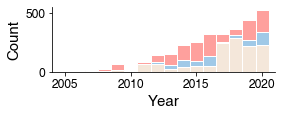

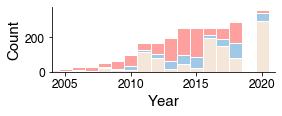

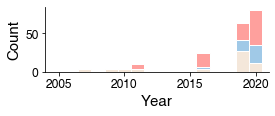

In [26]:
timelines = [
    ['2003', '2004', '2007', '2008', '2009', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    ['2000','2003','2004','2005','2006','2007','2008','2009','2010', '2011','2012','2013','2014','2015','2016','2017','2018','2020'], 
    ['2004','2007','2009','2010','2011','2016','2019','2020']
]
cities = ['bj', 'sh', 'sz']
list_k = ['13', '12', '6']

# i=2
for i in range(len(cities)):
    city_abbr = cities[i]
    timeline = timelines[i]
    pd_Sst = pd.DataFrame()

    for snapshot in timeline:
        # read the subway network of Beijing subway in 2019
        H0 = nx.read_gml('data/networks/PrimalGraph_'+city_abbr+'_'+snapshot+'.gml') 

        # read the information network of Beijing subway in 2019
        dualH_sub = nx.read_gml('data/networks/DualGraph_'+city_abbr+'_'+snapshot+'.gml', destringizer=int)  # the network is used for route matching and the transfer delay is set specifically based on the smart card data (Beijing: 402s, Shanghai: 431s, Shenzhen: 376s).

        dualH_nodes_sub = list(dualH_sub.nodes(data=True))
        dualH_edges_sub = list(dualH_sub.edges(data=True,keys=True))

        [matrix_Ss,
         matrix_nroutes,
         matrix_pathlength,
         matrix_pathdist,
         matrix_S_nid,
         matrix_S_nid_C1,
         matrix_S_nid_C2,
         matrix_S_nid_C3] = load_variable('data/output/TSI/' + city_abbr + '_' + snapshot + '.pkl')

        tmp_Sst = pd.concat([pd.DataFrame({
            's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
            't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
            'S':matrix_S_nid.flatten(), 'C':'all', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C1.flatten(), 'C':'1', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C2.flatten(), 'C':'2', 'snapshot':snapshot}),
            pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid_C3.flatten(), 'C':'3', 'snapshot':snapshot})
        ], axis=0, ignore_index=True)
        # len(set([list(dualH_sub[u][v])[0] for u,v in dualH_sub.edges()]))#
        tmp_Sst['Ktot'] = len(nx.Graph(dualH_sub).edges())
        tmp_Sst['k'] = '∞'
        pd_Sst = pd_Sst.append(tmp_Sst, ignore_index=True)
        for k in [list_k[i]]:
            [
                matrix_Ss_sub,
                matrix_nroutes_sub,
                matrix_pathlength_sub,
                matrix_pathdist_sub,
                matrix_Ktot_sub,
                matrix_S_nid,
                matrix_Ktot_st_sub,
                matrix_S_nid_C1,
                matrix_Ktot_st_C1_sub,
                matrix_S_nid_C2,
                matrix_Ktot_st_C2_sub,
                matrix_S_nid_C3,
                matrix_Ktot_st_C3_sub,
            ] = load_variable(
                'data/output/ESI/ksp_' +
                str(k) +
                '_' +
                city_abbr +
                '_' +
                snapshot +
                '.pkl')
            tmp_Sst = pd.concat([pd.DataFrame({
                's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                'S':matrix_S_nid.flatten(), 'C':'all', 'snapshot':snapshot,
                'Ktot':matrix_Ktot_st_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C1.flatten(), 'C':'1', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C1_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C2.flatten(), 'C':'2', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C2_sub.flatten()}),
                pd.DataFrame({
                    's': [i + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    't':[j + 1 for i in range(len(matrix_S_nid)) for j in range(len(matrix_S_nid[i]))],
                    'S':matrix_S_nid_C3.flatten(), 'C':'3', 'snapshot':snapshot,
                    'Ktot':matrix_Ktot_st_C3_sub.flatten()})], axis=0, ignore_index=True)

            tmp_Sst['k'] = str(k)
            pd_Sst = pd_Sst.append(tmp_Sst, ignore_index=True)

    pd_Sst = pd_Sst[(pd_Sst['S'] > -1) & (np.isnan(pd_Sst['S']) == False)]
    pd_Sst['st'] = pd_Sst['s'].astype(str) + '-' + pd_Sst['t'].astype(str)
    pd_Sst['snapshot_f'] = pd_Sst['snapshot']
    pd_Sst['snapshot_f'] = pd_Sst['snapshot_f'].astype(np.float)
    pd_Sst

    p1 = pd_Sst.merge(pd_Sst.groupby(by=['st', 'C', 's', 't', 'k'], as_index=False).agg(
        {'snapshot_f': np.min}), on=['st', 'C', 's', 't', 'k'])

    plt.figure(figsize=(4, 1.2))
    for pi in range(1, len(timeline)):

        snapshot = timeline[pi][:4]
        year = int(snapshot)
        last_year = int(timeline[pi - 1][:4])
        k = list_k[i]  # 7#
        idx = pi + 2

        pd_diff = p1[(p1['k'] == str(k)) 
                     & (p1['C'] == 'all') 
                     & (p1['snapshot_f_y'] < year) 
                     & (p1['snapshot_f_x'] == year)].merge(
            p1[(p1['k'] == str(k)) 
               & (p1['C'] == 'all')
               & (p1['snapshot_f_y'] < year) 
               & (p1['snapshot_f_x'] == last_year)]
            , on=['s', 't', 'C', 'k', 'st', 'snapshot_f_y'])
        
        pd_diff['S_diff'] = pd_diff['S_x'] - pd_diff['S_y']
        pd_diff.loc[pd_diff['S_diff'] < 0, 'diff'] = '-1'
        pd_diff.loc[pd_diff['S_diff'] == 0, 'diff'] = '0'
        pd_diff.loc[pd_diff['S_diff'] > 0, 'diff'] = '1'
        hh = sns.histplot(
            data=pd_diff, x="snapshot_f_x_x", hue="diff", multiple="stack", hue_order=[
                '1', '-1', '0'], palette=[
                color(
                    (254, 129, 125)), color(
                    (129, 184, 223)), color(
                        (241, 224, 206))], edgecolor='white')
    ax = plt.gca()
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlim(2004, 2021)

    label_vals = ax.get_xticks()

    plt.tick_params(labelsize=12)
    plt.xlabel('Year', fontdict={"family": "Helvetica", "fontsize": 15})
    plt.ylabel('Count', fontdict={"family": "Helvetica", "fontsize": 15})
    # plt.savefig('pic_timeline_sh/deltaS_1_'+str(k)+'_0.svg',format = "svg",dpi=600,transparent = True,bbox_inches = 'tight')
    # plt.savefig('pic_timeline_sh/deltaS_1_'+str(k)+'_0.png',format = "png",dpi=60,transparent = True,bbox_inches = 'tight')
    # # plt.savefig('pic_timeline/deltaS_1_'+str(k)+'.eps',dpi=600,transparent = True,bbox_inches = 'tight')
